# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [ ]:
# IMPORTS
%load_ext autoreload
%autoreload 2

import csv, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tasks.task import Task
from tasks.takeoff import Takeoff
from agents.basic_agent import Basic_Agent, Trivial_Takeoff_Agent
from agents.policy_search import PolicySearch_Agent
from agents.ddpg_agent import DDPG

# log and plot helper
import utility

In [ ]:
### TRIVIAL TEST ###

# Modify the values below to give the quadcopter a different starting position.

runtime = 25.                                     # time limit of the episode
init_pose = np.array([0., 0., 100., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.0, 0.0, 100.0])
file_output = 'trivial_takeoff_data.txt'                    # file name for saved results

# Setup
task = Takeoff(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
noise = 0
speed = 404
agent = Trivial_Takeoff_Agent(task, speed, noise)
# Run the simulation, and save the results.
results = utility.log_run(agent, file_output)
utility.plot_run(results)
utility.print_3d_trajectory(results)

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [ ]:
### BASIC AGENT ###

# Modify the values below to give the quadcopter a different starting position.

runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.0, 0.0, 10.0])
file_output = 'basic_agent_data.txt'                    # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = Basic_Agent(task)
# Run the simulation, and save the results.
results = utility.log_run(agent, file_output)
utility.plot_run(results)

In [ ]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

#### POLICY SEARCH AGENT

In [ ]:
### Training

num_episodes = 100
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 0., 0., 0., 0.])  # initial pose
target_pos = np.array([0., 0., 100.])
task = Takeoff(init_pose=init_pose, target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

This agent should perform very poorly on this task.  And that's where you come in!

In [ ]:
### Evaluation

file_output = 'plolicy_search_agent_data.txt'                    # file name for saved results

# Setup
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
utility.plot_run(results)
utility.print_3d_trajectory(results)

## Test Noise

In [ ]:
# UNDERSTANDING ORNSTEIN UHLENBECK NOISE #
from agents.ounoise import OUNoise

def plot_noise_process():
    %matplotlib inline
    # Noise process
    action_size = 1
    mu = 0.0
    theta = 0.03
    sigma = .0005
    noise_gen = OUNoise(action_size, mu, theta, sigma)

    noise = [noise_gen.sample() for _ in range(25)]

    plt.plot(noise)
    plt.show()
    
plot_noise_process()

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

### General Imports

In [105]:
import autoreload

%load_ext autoreload
%autoreload 2

import sys, csv, time, random
import numpy as np
np.random.seed(163758683)

import pandas as pd
import matplotlib.pyplot as plt

from agents.ddpg_agent import DDPG
from agents.ounoise import OUNoise
from agents.replay_buffer import ReplayBuffer
from tasks.task import Task
from tasks.takeoff import Takeoff
from tasks.landing import Landing
from tasks.hovering import Hovering
import utility

gen_num_episodes = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. TASK - TAKEOFF

In [106]:
%matplotlib notebook

num_episodes = 100
num_episodes = num_episodes if num_episodes else gen_num_episodes

# Takeoff task
# Quadcopter starts on (0,0,0) and has as target (0,0,100)

init_pos = np.array([0., 0., 0., 0., 0., 0.])
target_pos = np.array([0., 0., 100.])
takeoff = Takeoff(init_pose=init_pos, target_pos=target_pos)

# Agent
params = {}
params['dropout_rate'] = 0.3
params['sigma'] = 0.01
takeoff_agent = DDPG(takeoff, params)

# Scores for plotting
display_every = 1
y_lims_reward = [-1000.,30000.]

np.random.seed(47621347)

%matplotlib notebook
takeoff_scores, xs, ys1, ys2 = utility.train(takeoff_agent, takeoff, num_episodes, display_every, False, y_lims_reward)

Number of episodes:  100

Epi=   1, score=-21386.917, (best=-21386.917), reward=-85.46, penalty=185.46, pos=-19.35 -11.51 5.65, v=-10.93 -6.72 -8.3
penalties:  pos_x: 374.33  pos_y: 132.37  pos_z: 8902.05  euler: 6.91  v_x: 8.42  v_y: 4.78  v_z: 86.05  av_p: 0.0  av_t: 33.97508156449193  pos: 36114.88  velo: 873.74  av_all: 34.4  all: 37092.17

Epi=   2, score=-5014.498, (best=-5014.498), reward=-105.2, penalty=205.2, pos=-0.51 0.93 0.0, v=-2.1 2.6 -2.51
penalties:  pos_x: 0.26  pos_y: 0.87  pos_z: 10000.0  euler: 5.07  v_x: 1.6  v_y: 1.67  v_z: 97.49  av_p: 0.0  av_t: 9.01499559567031  pos: 40001.12  velo: 978.18  av_all: 9.85  all: 41039.85

Epi=   3, score=-630.051, (best=-630.051), reward=-105.02, penalty=205.02, pos=-0.0 0.0 0.0, v=-0.04 0.11 -0.03
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 0.35  v_x: 0.03  v_y: 0.1  v_z: 99.97  av_p: 0.0  av_t: 0.05372518021532412  pos: 40000.0  velo: 999.87  av_all: 0.05  all: 41003.43

Epi=   4, score=-315.016, (best=-315.016), 


Epi=  28, score=-314.971, (best=-314.971), reward=-104.99, penalty=204.99, pos=-0.0 0.0 0.0, v=-0.0 0.01 -0.5
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 0.2  v_x: 0.0  v_y: 0.01  v_z: 99.5  av_p: 0.0  av_t: 0.009611545826935615  pos: 40000.0  velo: 995.05  av_all: 0.01  all: 40997.1

Epi=  29, score=-314.966, (best=-314.966), reward=-104.98, penalty=204.98, pos=-0.0 0.0 0.0, v=-0.0 0.0 -0.51
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 0.17  v_x: 0.0  v_y: 0.0  v_z: 99.49  av_p: 0.0  av_t: 0.007052147979984658  pos: 40000.0  velo: 994.9  av_all: 0.01  all: 40996.6

Epi=  30, score=-314.961, (best=-314.961), reward=-104.98, penalty=204.98, pos=-0.0 0.0 0.0, v=-0.0 0.0 -0.52
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 0.14  v_x: 0.0  v_y: 0.0  v_z: 99.48  av_p: 0.0  av_t: 0.005007221764806369  pos: 40000.0  velo: 994.76  av_all: 0.01  all: 40996.15

Epi=  31, score=-314.957, (best=-314.957), reward=-104.98, penalty=204.98, pos=-0.0 0.0 0.0, v


Epi=  56, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 2.4602574952100822e-08  pos: 40000.0  velo: 994.11  av_all: 39.47  all: 41096.41

Epi=  57, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 1.630955058327958e-08  pos: 40000.0  velo: 994.11  av_all: 39.47  all: 41096.42

Epi=  58, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 1.0687079187562647e-08  pos: 40000.0  velo: 994.11  av_all: 39.47  all: 41096.42

Epi=  59, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0


Epi=  84, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 2.3452873965506528e-11  pos: 40000.0  velo: 994.11  av_all: 39.48  all: 41096.42

Epi=  85, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 1.529841793919102e-11  pos: 40000.0  velo: 994.11  av_all: 39.48  all: 41096.42

Epi=  86, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.0, v=0.0 0.0 -0.59
penalties:  pos_x: 0.0  pos_y: 0.0  pos_z: 10000.0  euler: 6.28  v_x: 0.0  v_y: 0.0  v_z: 99.41  av_p: 0.0  av_t: 1.329558842984653e-11  pos: 40000.0  velo: 994.11  av_all: 39.48  all: 41096.42

Epi=  87, score=-315.964, (best=-314.941), reward=-105.48, penalty=205.48, pos=0.0 0.0 0.

### 1. Task: Takeoff - Plot Scores / Single Episode Evaluation

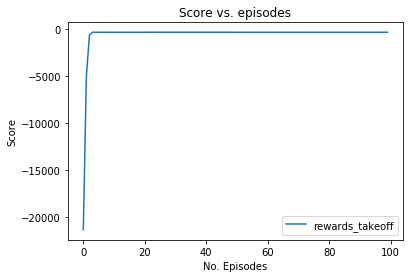

final_reward:  -315.9642307163738


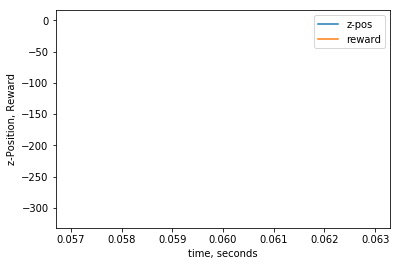

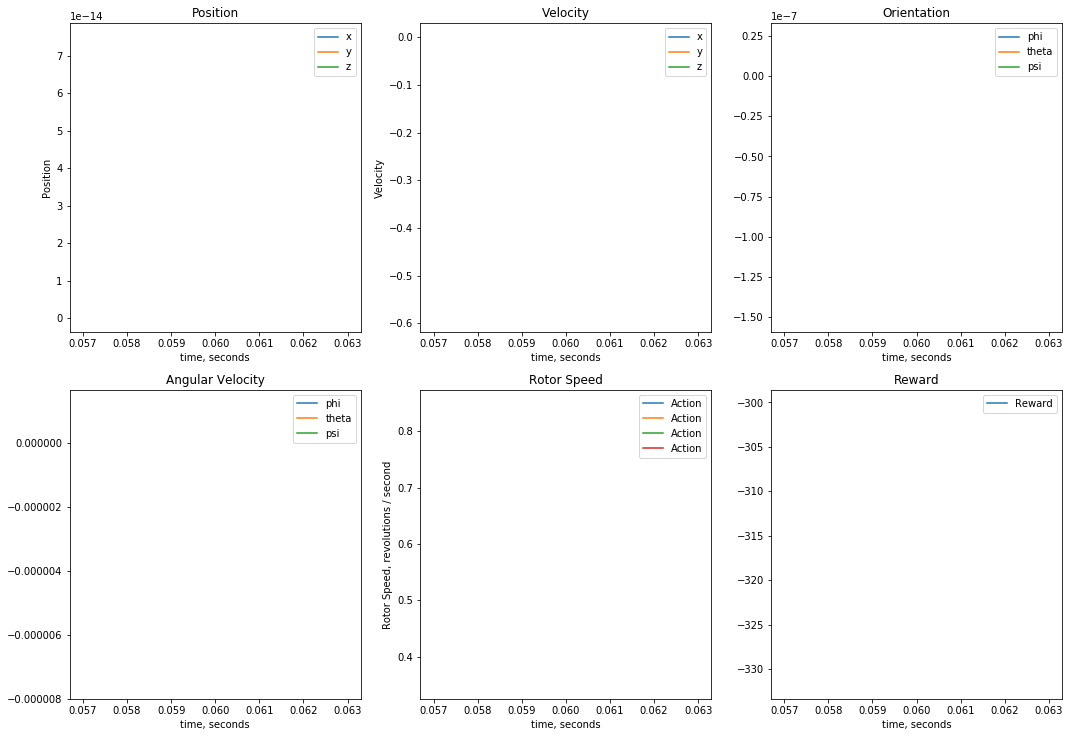

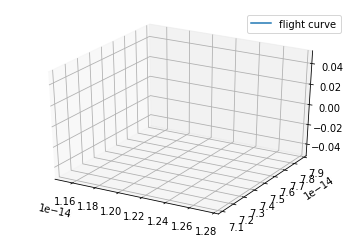

In [107]:
%matplotlib inline
utility.evaluate_episode(takeoff_agent, takeoff_scores, "takeoff")

#### END TASK TAKEOFF

## 2. TASK - LANDING

In [93]:
### DELETE BELOW ON FINISH

import autoreload

%load_ext autoreload
%autoreload 2

import sys, csv, time, random
import numpy as np
np.random.seed(39815788)

import pandas as pd
import matplotlib.pyplot as plt

from agents.ddpg_agent import DDPG
from agents.ounoise import OUNoise
from agents.replay_buffer import ReplayBuffer
from tasks.task import Task
from tasks.takeoff import Takeoff
from tasks.landing import Landing
from tasks.hovering import Hovering
import utility

gen_num_episodes = 300

### DELETE ABOVE ON FINISH

%matplotlib notebook

num_episodes = 100
num_episodes = num_episodes if num_episodes else gen_num_episodes

# Landing task
# Quadcopter starts on (0,0,100) and has as target (0,0,0)

init_pos = np.array([0., 0., 100., 0., 0., 0.])
init_velocities = np.array([0.0, 0.0, 0.0])
target_pos = np.array([0., 0., 0.])
landing = Landing(init_pose=init_pos, init_velocities=init_velocities, target_pos=target_pos, runtime=5.)

params = {}
params['sigma'] = 0.1
params['dropout_rate'] = 0.2
params['size_multiplicator'] = 2
params['batch_size'] = 64
params['batch_norm'] = False

# Agent
landing_agent = DDPG(landing, params)

# Scores for plotting
display_every = 1
y_lims_reward = [-7000000.,0.]

np.random.seed(75800345)

landing_scores, xs, ys1, ys2 = utility.train(landing_agent, landing, num_episodes, display_every, False, y_lims_reward)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of episodes:  100

Epi=   1, score=-33025.069, (best=-33025.069), reward=8089.94, penalty=10.06, pos=8.36 0.45 0.0, v=11.02 0.0 -133.53
penalties:  pos_xy: 70.1  pos_z: 0.0  euler: 7.24  v_x: 11.02  v_y: 0.0  v_z: -133.53  pos: 70.1  velo: -122.51  extra_v_penalty_1: 71321.0436  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 71321.0436

Epi=   2, score=58897.917, (best=58897.917), reward=3093.43, penalty=6.57, pos=-14.44 -4.55 4.33, v=-2.16 0.31 -22.95
penalties:  pos_xy: 229.23  pos_z: 18.72  euler: 4.64  v_x: 2.16  v_y: 0.31  v_z: -22.95  pos: 416.4  velo: -20.48  extra_v_penalty_1: 2106.81  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 71321.0436

Epi=   3, score=-54655.526, (best=58897.917), reward=8050.73, penalty=49.27, pos=0.0 0.0 0.0, v=0.01 0.0 -1510.74
penalties:  pos_xy: 0.0  pos_z: 0.0  euler: 6.28  v_x: 0.01  v_y: 0.0  v_z: -1510.74  pos: 


Epi=  25, score=-16542.814, (best=121962.460), reward=3093.0, penalty=7.0, pos=2.37 -13.09 0.0, v=2.97 -13.28 -63.42
penalties:  pos_xy: 177.0  pos_z: 0.0  euler: 6.66  v_x: 2.97  v_y: 13.28  v_z: -63.42  pos: 177.0  velo: -47.17  extra_v_penalty_1: 16088.385600000001  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 25526.452900000004

Epi=  26, score=-20417.938, (best=121962.460), reward=3094.94, penalty=5.06, pos=1.19 -13.5 0.0, v=0.77 -23.3 -69.65
penalties:  pos_xy: 183.55  pos_z: 0.0  euler: 4.78  v_x: 0.77  v_y: 23.3  v_z: -69.65  pos: 183.55  velo: -45.58  extra_v_penalty_1: 19404.49  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 25526.452900000004

Epi=  27, score=129712.552, (best=129712.552), reward=8093.28, penalty=6.72, pos=0.35 1.84 0.0, v=1.75 2.69 -37.32
penalties:  pos_xy: 3.49  pos_z: 0.0  euler: 7.43  v_x: 1.75  v_y: 2.69  v_z: -37.32  pos: 3.49  velo: -32.88  extra_v_penalty_1: 5572.6225  extra_reward_1: 3000.0  extra_reward_2


Epi=  49, score=-193266.098, (best=129712.552), reward=-669.29, penalty=769.29, pos=5.13 -61.22 85.31, v=1.28 -20.39 -1.58
penalties:  pos_xy: 3773.85  pos_z: 7277.79  euler: 5.98  v_x: 1.28  v_y: 20.39  v_z: -1.58  pos: 76551.79  velo: 20.09  extra_v_penalty_1: 3598.8001000000004  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3425.7609

Epi=  50, score=-171757.340, (best=129712.552), reward=-160.24, penalty=260.24, pos=6.61 46.19 48.63, v=0.23 1.15 -28.88
penalties:  pos_xy: 2177.22  pos_z: 2364.8  euler: 4.76  v_x: 0.23  v_y: 1.15  v_z: -28.88  pos: 25825.2  velo: -27.5  extra_v_penalty_1: 3598.8001000000004  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3425.7609

Epi=  51, score=-55924.656, (best=129712.552), reward=3085.4, penalty=14.6, pos=6.58 15.99 9.2, v=0.4 -10.11 -30.4
penalties:  pos_xy: 299.04  pos_z: 84.66  euler: 5.23  v_x: 0.4  v_y: 10.11  v_z: -30.4  pos: 1145.67  velo: -19.88  extra_v_penalty_1: 3695.4240999999997  extra_rewa


Epi=  73, score=-403218.658, (best=152485.818), reward=-2624.48, penalty=2724.48, pos=7.94 0.0 164.95, v=9.81 0.0 13.17
penalties:  pos_xy: 62.98  pos_z: 27208.13  euler: 5.29  v_x: 9.81  v_y: 0.0  v_z: 13.17  pos: 272144.32  velo: 22.99  extra_v_penalty_1: 7040.888099999999  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3411.7281

Epi=  74, score=-405643.561, (best=152485.818), reward=-2644.79, penalty=2744.79, pos=6.34 -0.0 165.21, v=5.76 -0.0 14.5
penalties:  pos_xy: 40.25  pos_z: 27292.92  euler: 12.2  v_x: 5.76  v_y: 0.0  v_z: 14.5  pos: 272969.46  velo: 20.26  extra_v_penalty_1: 7040.888099999999  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3411.7281

Epi=  75, score=-401560.486, (best=152485.818), reward=-2558.77, penalty=2658.77, pos=16.68 -0.0 162.56, v=12.02 -0.0 11.33
penalties:  pos_xy: 278.24  pos_z: 26427.19  euler: 11.42  v_x: 12.02  v_y: 0.0  v_z: 11.33  pos: 264550.12  velo: 23.34  extra_v_penalty_1: 7040.888099999999  extra


Epi=  96, score=-398358.062, (best=152485.818), reward=-2389.84, penalty=2489.84, pos=-17.95 0.0 157.65, v=-16.81 0.0 -4.99
penalties:  pos_xy: 322.24  pos_z: 24854.32  euler: 3.26  v_x: 16.81  v_y: 0.0  v_z: -4.99  pos: 248865.4  velo: 11.82  extra_v_penalty_1: 7040.888099999999  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3411.7281

Epi=  97, score=-344445.992, (best=152485.818), reward=-1292.29, penalty=1392.29, pos=-19.42 0.0 117.66, v=3.37 -0.0 -10.06
penalties:  pos_xy: 377.23  pos_z: 13843.42  euler: 6.52  v_x: 3.37  v_y: 0.0  v_z: -10.06  pos: 138811.48  velo: -6.69  extra_v_penalty_1: 7040.888099999999  extra_reward_1: 3000.0  extra_reward_2: 8000.0  extra_v_penalty_2: 3411.7281

Epi=  98, score=-313663.403, (best=152485.818), reward=-1184.14, penalty=1284.14, pos=48.46 -5.03 111.65, v=27.5 -0.18 -9.49
penalties:  pos_xy: 2373.66  pos_z: 12466.5  euler: 11.65  v_x: 27.5  v_y: 0.18  v_z: -9.49  pos: 127038.71  velo: 18.19  extra_v_penalty_1: 7040.8880999

### 2. Task: Landing - Plot Scores / Single Episode Evaluation

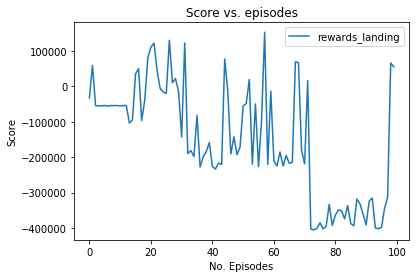

final_reward:  213.42897613033153


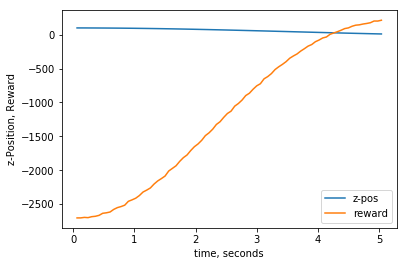

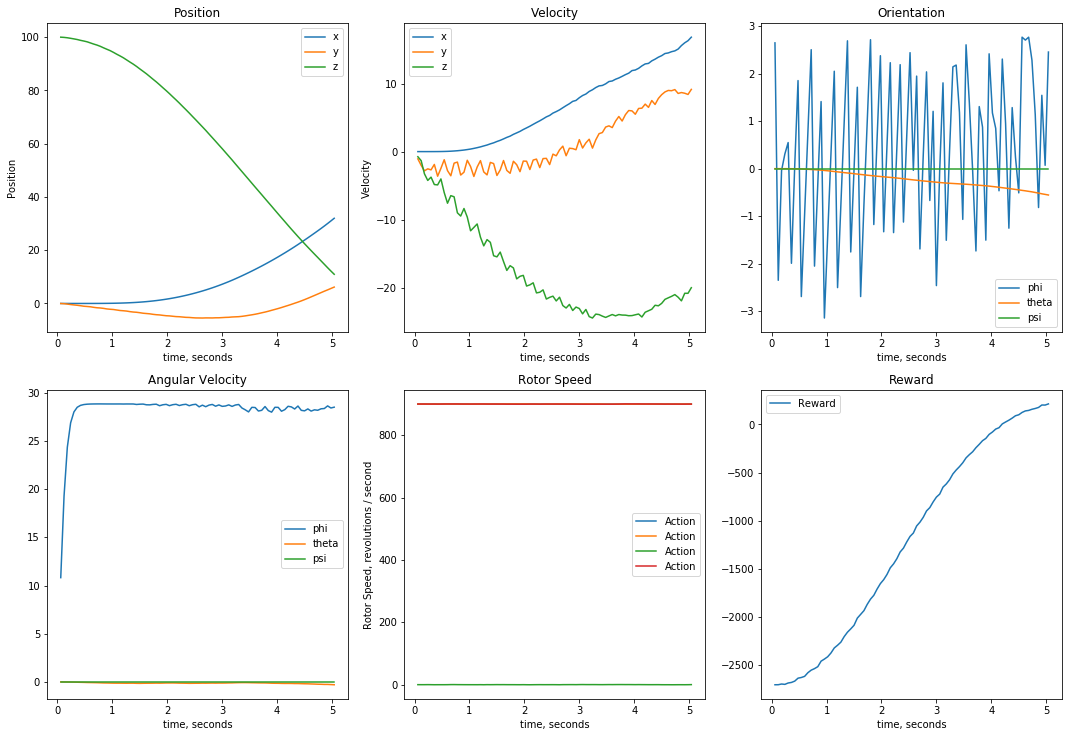

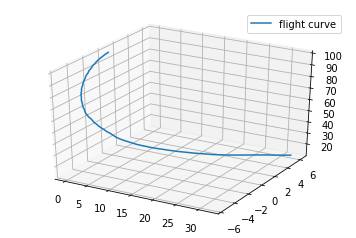

In [94]:
%matplotlib inline
utility.evaluate_episode(landing_agent, landing_scores, "landing")

#### END LANDING OPERATION

## 3. TASK - HOVERING

In [ ]:
%matplotlib notebook

num_episodes = 100
num_episodes = num_episodes if num_episodes else gen_num_episodes

# Hovering task
# Quadcopter starts on (0,0,100) and has as target (0,0,100)

init_pos = np.array([0., 0., 100., 0., 0., 0.])
target_pos = np.array([0., 0., 100.])
hovering = Hovering(init_pose=init_pos, target_pos=target_pos,runtime=5.)

sigma = 0.1
params['sigma'] = sigma

# Agent
hovering_agent = DDPG(hovering, params)

# Scores for plotting
display_every = 1
y_lims_reward = [-10000.,30000.]

np.random.seed(23405452)

hovering_scores, xs, ys1, ys2 = utility.train(hovering_agent, hovering, num_episodes, 
                                              display_every, False, y_lims_reward)

### 3. Task: Hovering - Plot Scores / Single Episode Evaluation

In [ ]:
%matplotlib inline
utility.evaluate_episode(hovering_agent, hovering_scores, "hovering")

#### END HOVERING OPERATION

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

#### Tasks

I created 3 classes inherting from task describing: takeoff (start from [0,0,0] to [0,0,100]),  landing (start from [0,0,100] to [0,0,0]) and hovering (staying at [0,0,100]). Only takeoff and landing could be accomplished, hence I will only discuss the functions here. I extended the state: the original is comprised of sim.pose and euler angles, my extend version also includes velocities and angular_velocities in order to give more data to the neural networks. They can be found in the tasks folder

#### Reward function for takeoff:
The final reward consists of a base reward (100) and penalties for:
* euler angle orientation different from 0,0,0
* residual distance for all axis x,y,z - each squared and with a 10x weight for the z-distance
* 

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: